In [14]:
!pip install yfinance

!pip install arch

In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from tqdm import tqdm
from datetime import datetime, timedelta
import warnings

In [27]:
warnings.filterwarnings('ignore')

In [28]:
# Define ticker symbols and date ranges
ticker = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'JPM', 'V']
start_date = '2010-01-01'
end_date = '2024-12-31'
train_end = '2023-12-31'
test_start = '2024-01-01'

# Download adjusted close data
data = yf.download(ticker, start=start_date, end=end_date)

# Keep only the 'Close' price for each ticker
close_data = data['Close'].copy()

# Compute log returns (or log prices)
log_close_data = np.log(close_data)

# Now you have a DataFrame of log prices
# If you still want to keep them in a combined DataFrame:
log_data = pd.concat([close_data, log_close_data], axis=1, keys=['Close', 'LogClose'])

# Optional: View the structure
print(log_data.head())


[*********************100%***********************]  10 of 10 completed

               Close                                                           \
Ticker          AAPL    AMZN      BRK-B      GOOGL        JPM META       MSFT   
Date                                                                            
2010-01-04  6.431896  6.6950  66.220001  15.590931  28.829172  NaN  23.211439   
2010-01-05  6.443016  6.7345  66.540001  15.522273  29.387598  NaN  23.218937   
2010-01-06  6.340532  6.6125  66.199997  15.130976  29.549067  NaN  23.076447   
2010-01-07  6.328808  6.5000  66.459999  14.778734  30.134396  NaN  22.836462   
2010-01-08  6.370887  6.6760  66.440002  14.975752  30.060390  NaN  22.993942   

                                      LogClose                                \
Ticker          NVDA TSLA          V      AAPL      AMZN     BRK-B     GOOGL   
Date                                                                           
2010-01-04  0.423854  NaN  19.719204  1.861269  1.901361  4.192983  2.746689   
2010-01-05  0.430044  NaN  19.4

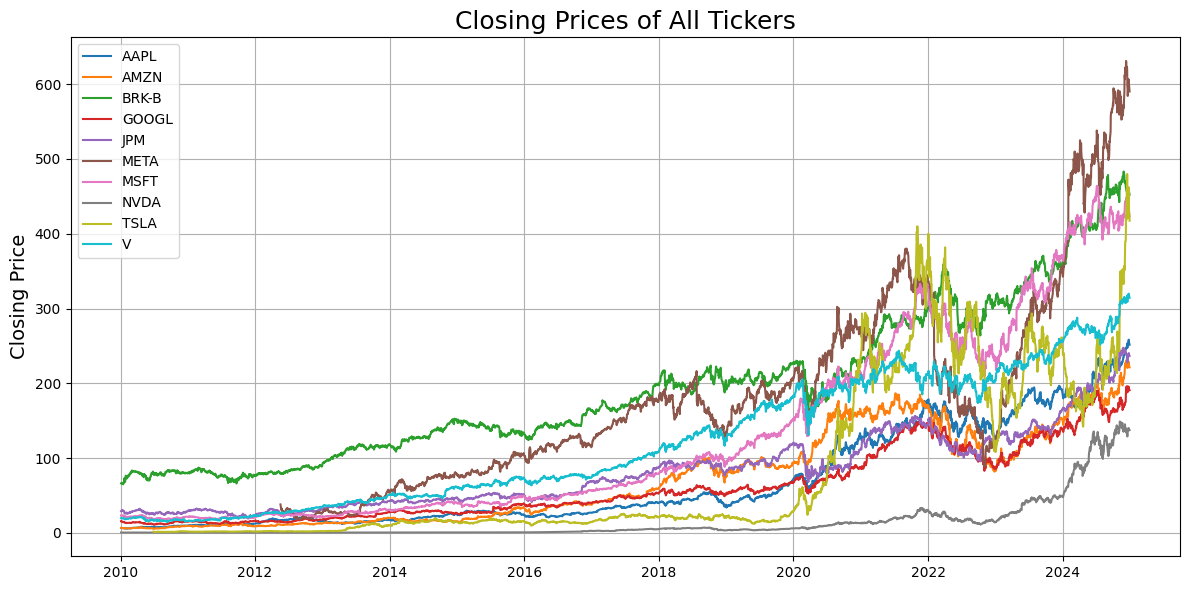

In [29]:
plt.figure(figsize=(12, 6))

for ticker in data['Close'].columns:
    plt.plot(data['Close'][ticker], label=ticker)

plt.ylabel('Closing Price', fontsize=14)
plt.title('Closing Prices of All Tickers', fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
log_price = log_close_data.copy()
log_train = log_price.loc[:train_end].copy()
log_test = log_price.loc[test_start:].copy()

In [31]:
# Clean missing data
log_train = log_train.dropna()
log_test = log_test.dropna()


In [32]:
# 3. Rolling forecast setup
history = log_train.copy()
predictions = []
pred_index = []

In [11]:
# ARIMA grid search parameters
p_range = range(0, 6)
d = 1
q_range = range(0, 6)

# Store best results
summary = []

# Loop through each ticker
for ticker in tickers:
    series = log_data[ticker].dropna()  # log price series
    print(f"\nRunning ARIMA grid search for {ticker}...")
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(series, order=(p, d, q))
                fitted = model.fit()
                results.append({
                    'p': p, 'd': d, 'q': q,
                    'AIC': fitted.aic,
                    'BIC': fitted.bic,
                    'model': fitted
                })
            except Exception:
                continue

    df = pd.DataFrame(results)

    if df.empty:
        print(f"  No ARIMA model could be fitted for {ticker}.")
        continue

    best_aic = df.loc[df['AIC'].idxmin()]
    best_bic = df.loc[df['BIC'].idxmin()]

    print(f"  Best AIC: ARIMA{(best_aic.p, best_aic.d, best_aic.q)} with AIC = {best_aic.AIC:.2f}")
    print(f"  Best BIC: ARIMA{(best_bic.p, best_bic.d, best_bic.q)} with BIC = {best_bic.BIC:.2f}")

    summary.append({
        'Ticker': ticker,
        'Best_AIC_Order': (best_aic.p, best_aic.d, best_aic.q),
        'Best_AIC': best_aic.AIC,
        'Best_BIC_Order': (best_bic.p, best_bic.d, best_bic.q),
        'Best_BIC': best_bic.BIC
    })

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary)
print("\n=== Summary of Best Models ===")
print(summary_df)


[*********************100%***********************]  10 of 10 completed



Running ARIMA grid search for AAPL...
  Best AIC: ARIMA(np.int64(2), np.int64(1), np.int64(5)) with AIC = -19804.31
  Best BIC: ARIMA(np.int64(0), np.int64(1), np.int64(0)) with BIC = -19770.36

Running ARIMA grid search for MSFT...
  Best AIC: ARIMA(np.int64(3), np.int64(1), np.int64(5)) with AIC = -20494.69
  Best BIC: ARIMA(np.int64(0), np.int64(1), np.int64(1)) with BIC = -20452.91

Running ARIMA grid search for NVDA...
  Best AIC: ARIMA(np.int64(3), np.int64(1), np.int64(4)) with AIC = -16164.14
  Best BIC: ARIMA(np.int64(1), np.int64(1), np.int64(0)) with BIC = -16138.98

Running ARIMA grid search for AMZN...
  Best AIC: ARIMA(np.int64(0), np.int64(1), np.int64(0)) with AIC = -18586.38
  Best BIC: ARIMA(np.int64(0), np.int64(1), np.int64(0)) with BIC = -18580.15

Running ARIMA grid search for GOOGL...
  Best AIC: ARIMA(np.int64(3), np.int64(1), np.int64(5)) with AIC = -19956.96
  Best BIC: ARIMA(np.int64(0), np.int64(1), np.int64(0)) with BIC = -19943.67

Running ARIMA grid sear

In [12]:

# Store all forecast results
all_bic_forecasts = {}

for i, row in summary_df.iterrows():
    ticker = row['Ticker']
    order = tuple(row['Best_BIC_Order'])

    print(f"\nRolling forecast for {ticker} using BIC-optimal ARIMA{order}...")

    series = log_data[ticker].dropna()
    log_train = series.loc[:train_end].copy()
    log_test = series.loc[test_start:].copy()

    if log_test.empty or log_train.empty:
        print(f"  Skipping {ticker}: insufficient data.")
        continue

    history = log_train.copy()
    predictions = []
    actuals = []
    pred_index = []

    for current_time in tqdm(log_test.index, desc=f"Forecasting {ticker}"):
        try:
            model = ARIMA(history, order=order, trend='t')  # use drift
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)
            pred_value = float(forecast)

            predictions.append(pred_value)
            actuals.append(log_test.loc[current_time])
            pred_index.append(current_time)

            # Add current observation to history
            history.loc[current_time] = log_test.loc[current_time]
        except Exception as e:
            print(f"  Error at {current_time}: {e}")
            continue

    # Save results
    result_df = pd.DataFrame({
        'Predicted': predictions,
        'Actual': actuals
    }, index=pred_index)

    all_bic_forecasts[ticker] = result_df

# Combine all into a single DataFrame
bic_combined_forecasts = pd.concat(all_bic_forecasts, names=['Ticker', 'Date'])
bic_combined_forecasts.index = bic_combined_forecasts.index.set_names(['Ticker', 'Date'])

print("\n✅ Rolling forecasts with BIC-optimal ARIMA models completed.")



Rolling forecast for AAPL using BIC-optimal ARIMA(np.int64(0), np.int64(1), np.int64(0))...


Forecasting AAPL: 100%|██████████| 251/251 [04:05<00:00,  1.02it/s]



Rolling forecast for MSFT using BIC-optimal ARIMA(np.int64(0), np.int64(1), np.int64(1))...


Forecasting MSFT: 100%|██████████| 251/251 [06:37<00:00,  1.59s/it]



Rolling forecast for NVDA using BIC-optimal ARIMA(np.int64(1), np.int64(1), np.int64(0))...


Forecasting NVDA: 100%|██████████| 251/251 [01:17<00:00,  3.23it/s]



Rolling forecast for AMZN using BIC-optimal ARIMA(np.int64(0), np.int64(1), np.int64(0))...


Forecasting AMZN: 100%|██████████| 251/251 [04:02<00:00,  1.03it/s]



Rolling forecast for GOOGL using BIC-optimal ARIMA(np.int64(0), np.int64(1), np.int64(0))...


Forecasting GOOGL: 100%|██████████| 251/251 [03:43<00:00,  1.12it/s]



Rolling forecast for META using BIC-optimal ARIMA(np.int64(0), np.int64(1), np.int64(0))...


Forecasting META: 100%|██████████| 251/251 [03:16<00:00,  1.28it/s]



Rolling forecast for TSLA using BIC-optimal ARIMA(np.int64(0), np.int64(1), np.int64(0))...


Forecasting TSLA: 100%|██████████| 251/251 [03:27<00:00,  1.21it/s]



Rolling forecast for BRK-B using BIC-optimal ARIMA(np.int64(1), np.int64(1), np.int64(0))...


Forecasting BRK-B: 100%|██████████| 251/251 [03:07<00:00,  1.34it/s]



Rolling forecast for JPM using BIC-optimal ARIMA(np.int64(2), np.int64(1), np.int64(0))...


Forecasting JPM: 100%|██████████| 251/251 [05:39<00:00,  1.35s/it]



Rolling forecast for V using BIC-optimal ARIMA(np.int64(1), np.int64(1), np.int64(0))...


Forecasting V: 100%|██████████| 251/251 [01:00<00:00,  4.17it/s]


✅ Rolling forecasts with BIC-optimal ARIMA models completed.


In [14]:
# Store
predictions.append(pred_value)
pred_index.append(current_time)

In [15]:
# Create a Series of predictions
log_pred_series = pd.Series(data=predictions, index=pred_index)

In [16]:
# 4. Evaluate residuals on log-scale
residuals = log_test.loc[log_pred_series.index] - log_pred_series


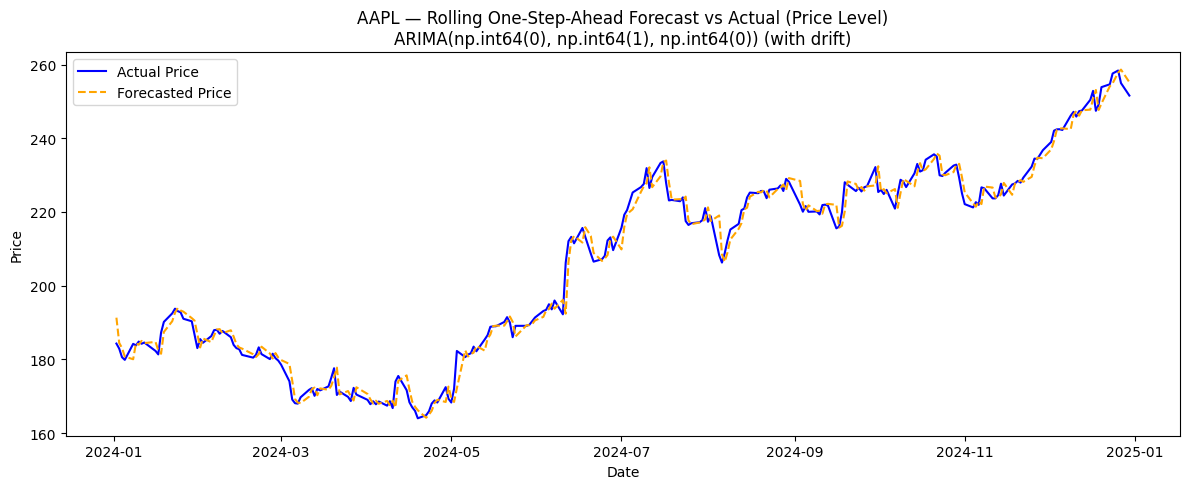

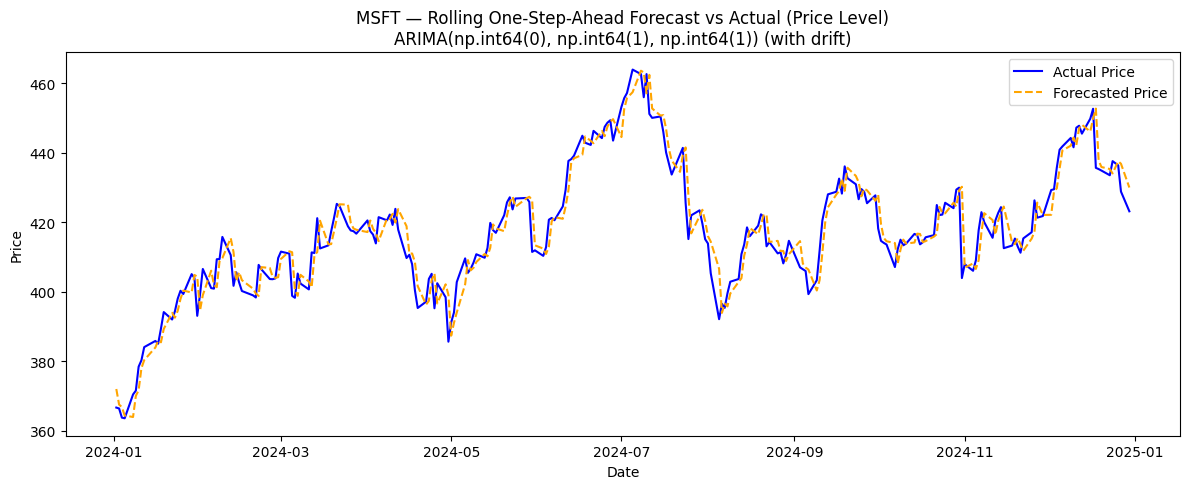

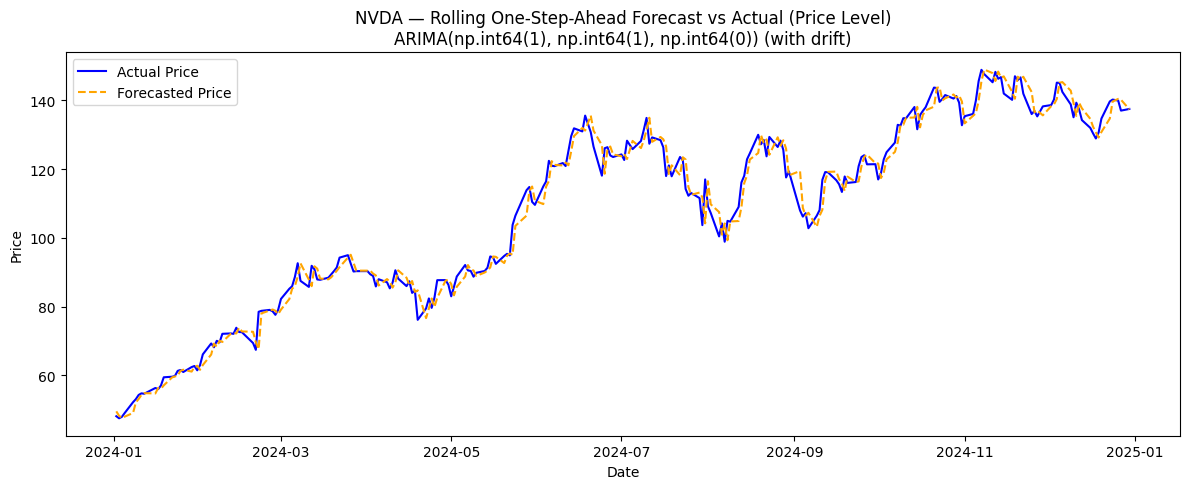

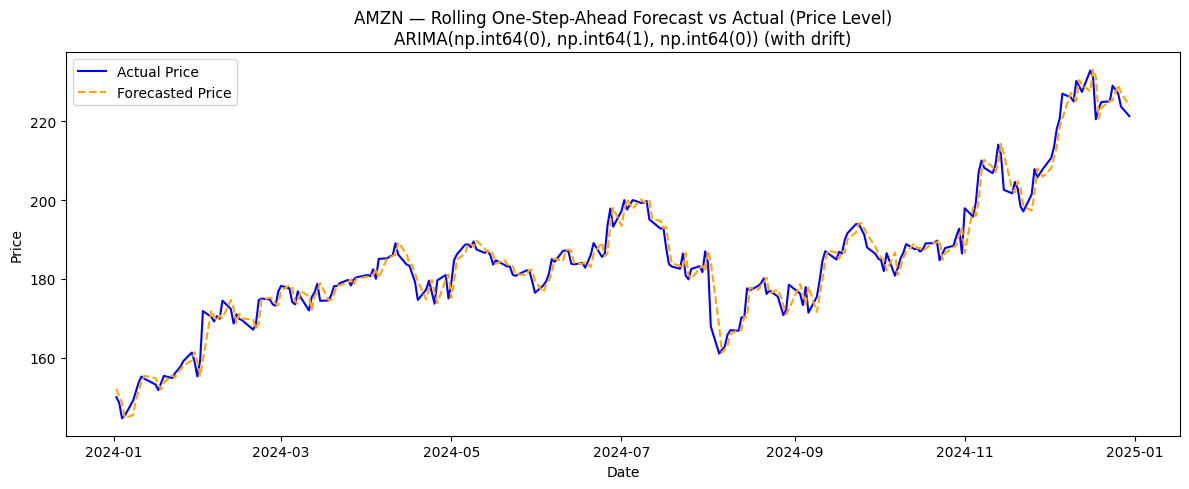

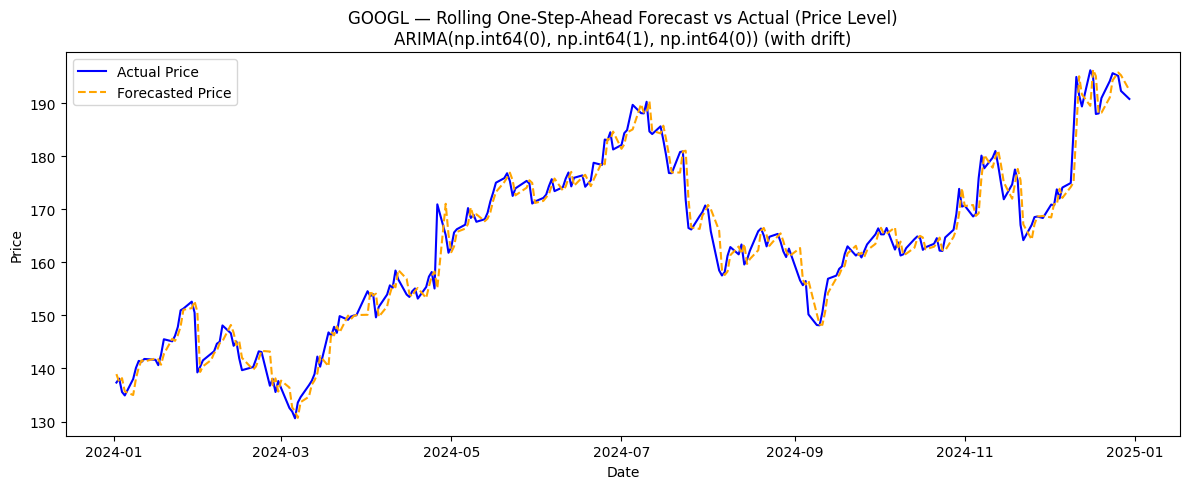

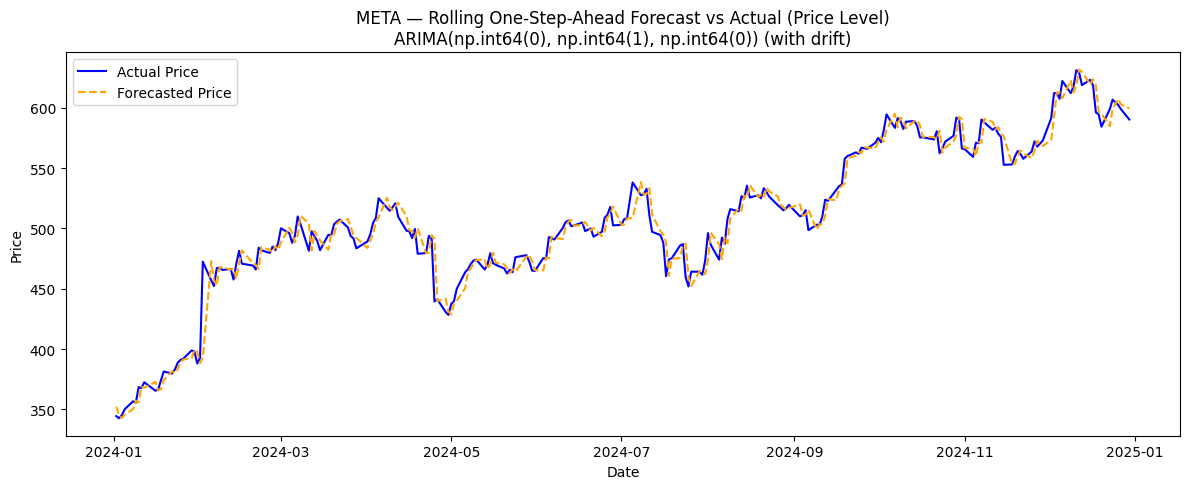

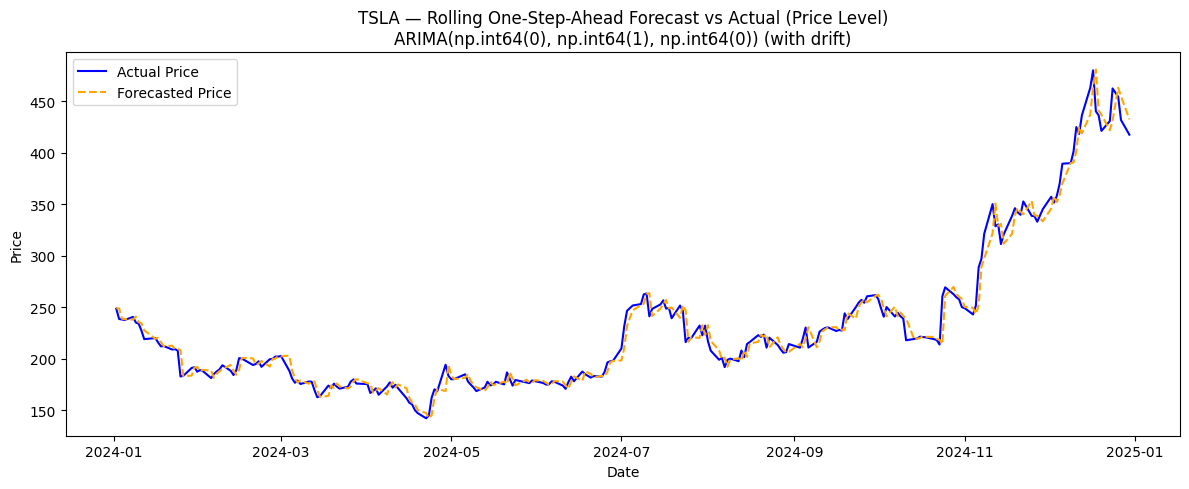

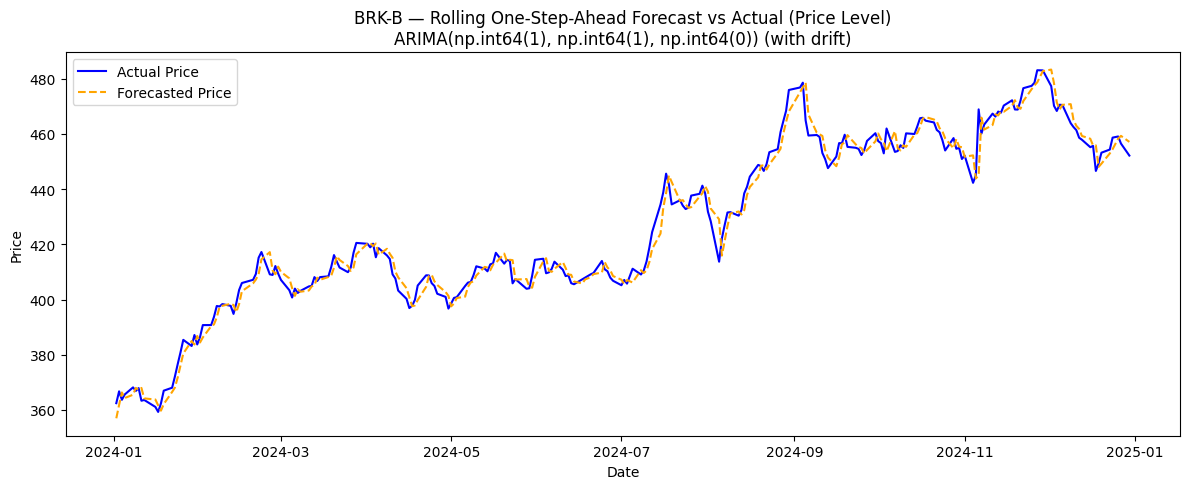

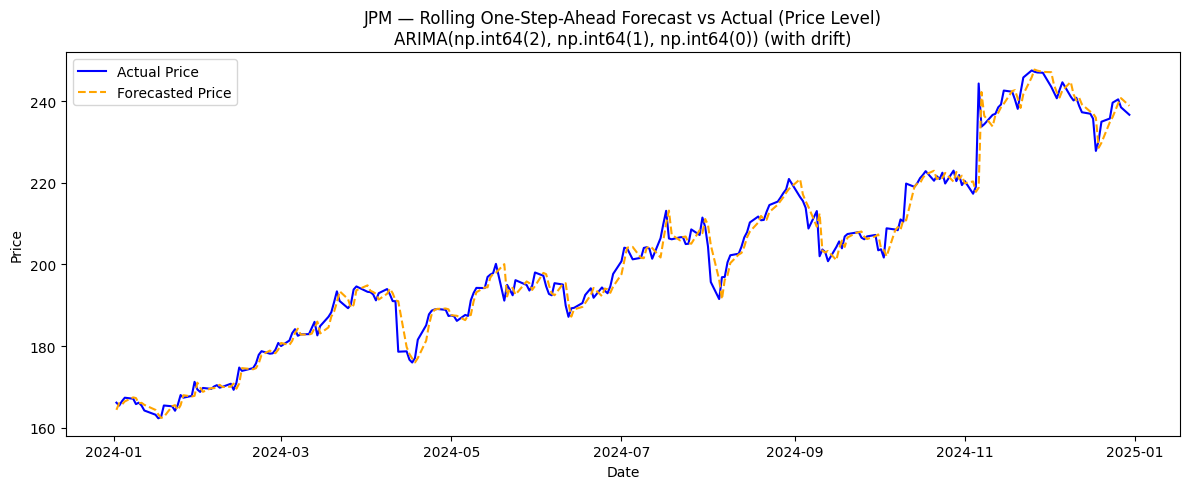

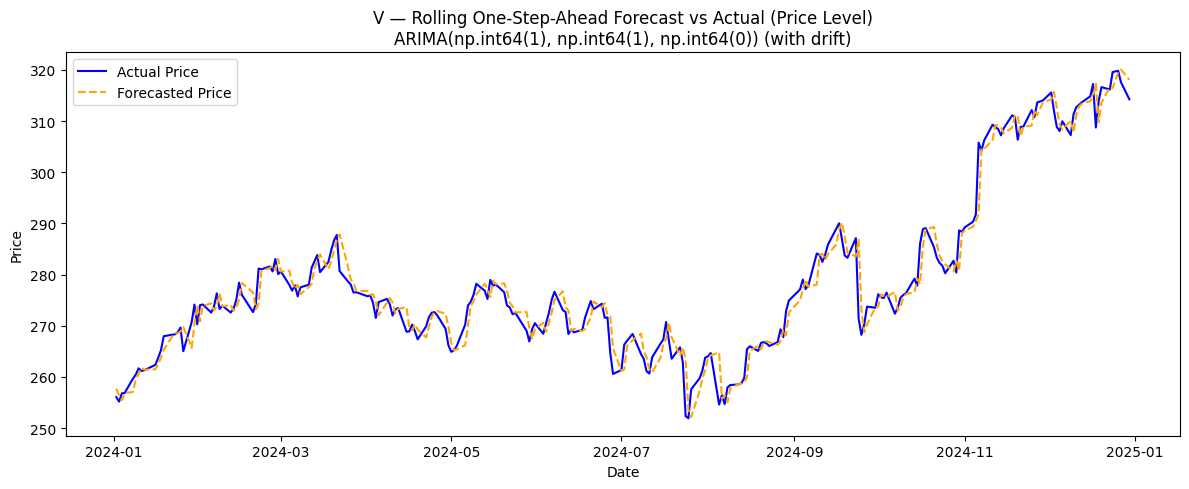

In [17]:
# Loop through each ticker in the forecast DataFrame
for ticker in bic_combined_forecasts.index.get_level_values('Ticker').unique():
    df_ticker = bic_combined_forecasts.loc[ticker]

    # Drop NaNs (if any)
    df_ticker = df_ticker.dropna()

    if df_ticker.empty:
        print(f"Skipping {ticker}: no valid predictions.")
        continue

    # Transform back to price scale from log scale
    price_pred = np.exp(df_ticker['Predicted'])
    price_actual = np.exp(df_ticker['Actual'])

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(price_actual, label='Actual Price', color='blue')
    plt.plot(price_pred, label='Forecasted Price', color='orange', linestyle='--')
    plt.title(f'{ticker} — Rolling One-Step-Ahead Forecast vs Actual (Price Level)\n'
              f'ARIMA{summary_df.loc[summary_df.Ticker == ticker, "Best_BIC_Order"].values[0]} (with drift)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
# Store results
metrics_list = []

# Loop over each ticker
for ticker in bic_combined_forecasts.index.get_level_values('Ticker').unique():
    df_ticker = bic_combined_forecasts.loc[ticker].dropna()

    if df_ticker.empty:
        continue

    # Transform from log-scale to price-scale
    price_actual = np.exp(df_ticker['Actual'])
    price_pred = np.exp(df_ticker['Predicted'])

    # Compute metrics
    mae = mean_absolute_error(price_actual, price_pred)
    rmse = np.sqrt(((price_actual - price_pred) ** 2).mean())

    metrics_list.append({
        'Ticker': ticker,
        'MAE': mae,
        'RMSE': rmse
    })

# Create summary DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display results
print("\n✅ Price-scale Forecast Error Metrics (MAE & RMSE):")
print(metrics_df.round(6))



✅ Price-scale Forecast Error Metrics (MAE & RMSE):
  Ticker       MAE       RMSE
0   AAPL  2.113257   2.893007
1   MSFT  3.957689   5.281071
2   NVDA  2.625755   3.494935
3   AMZN  2.427970   3.262686
4  GOOGL  2.065236   2.894511
5   META  7.344685  10.884942
6   TSLA  6.763185   9.896761
7  BRK-B  3.040892   4.051161
8    JPM  1.965367   3.082341
9      V  2.122103   2.980997


In [19]:
# Ensure forecast window is forward-looking
latest_date = log_data.index.max()
future_dates = pd.bdate_range(start=latest_date + pd.Timedelta(days=1), periods=5)

forecast_future = {}

# Loop over each ticker and forecast 5 days into the future
for _, row in summary_df.iterrows():
    ticker = row['Ticker']
    order = tuple(row['Best_BIC_Order'])

    print(f"\nForecasting future 5 days for {ticker} using ARIMA{order}...")

    series = log_data[ticker].dropna()

    try:
        model = ARIMA(series, order=order, trend='t')
        model_fit = model.fit()

        # Forecast 5 future days
        fc_log = model_fit.forecast(steps=5)
        fc_price = np.exp(fc_log)
        fc_price.index = future_dates

        forecast_future[ticker] = fc_price

    except Exception as e:
        print(f"  Error forecasting {ticker}: {e}")
        continue

# Combine all forecasts into one DataFrame
forecast_future_df = pd.DataFrame(forecast_future)

print("\n✅ Future 5-Day Ahead Forecast (Price Scale):")
print(forecast_future_df.round(2))



Forecasting future 5 days for AAPL using ARIMA(np.int64(0), np.int64(1), np.int64(0))...

Forecasting future 5 days for MSFT using ARIMA(np.int64(0), np.int64(1), np.int64(1))...

Forecasting future 5 days for NVDA using ARIMA(np.int64(1), np.int64(1), np.int64(0))...

Forecasting future 5 days for AMZN using ARIMA(np.int64(0), np.int64(1), np.int64(0))...

Forecasting future 5 days for GOOGL using ARIMA(np.int64(0), np.int64(1), np.int64(0))...

Forecasting future 5 days for META using ARIMA(np.int64(0), np.int64(1), np.int64(0))...

Forecasting future 5 days for TSLA using ARIMA(np.int64(0), np.int64(1), np.int64(0))...

Forecasting future 5 days for BRK-B using ARIMA(np.int64(1), np.int64(1), np.int64(0))...

Forecasting future 5 days for JPM using ARIMA(np.int64(2), np.int64(1), np.int64(0))...

Forecasting future 5 days for V using ARIMA(np.int64(1), np.int64(1), np.int64(0))...

✅ Future 5-Day Ahead Forecast (Price Scale):
              AAPL    MSFT    NVDA    AMZN   GOOGL    ME

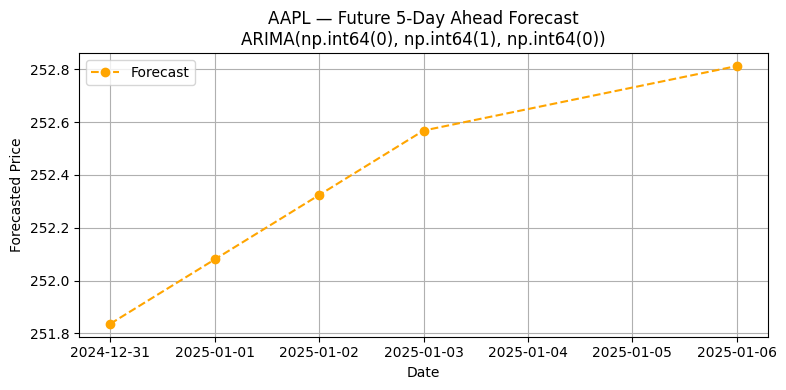

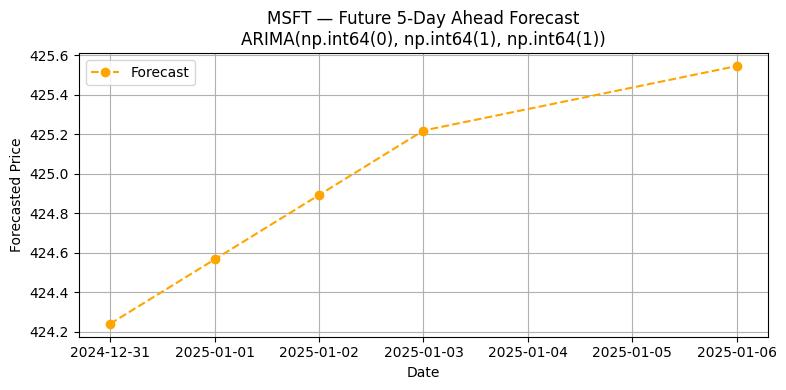

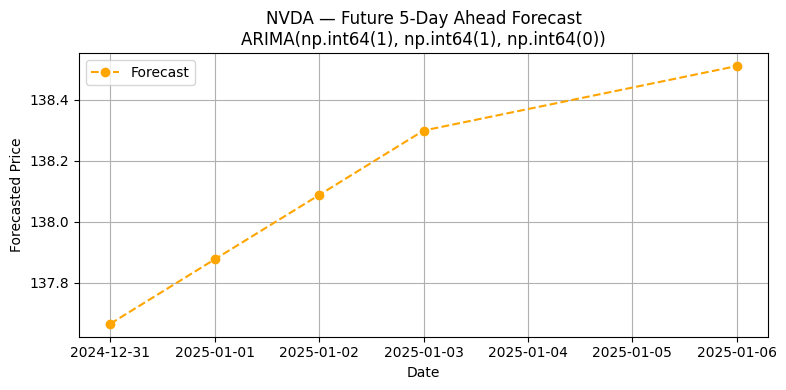

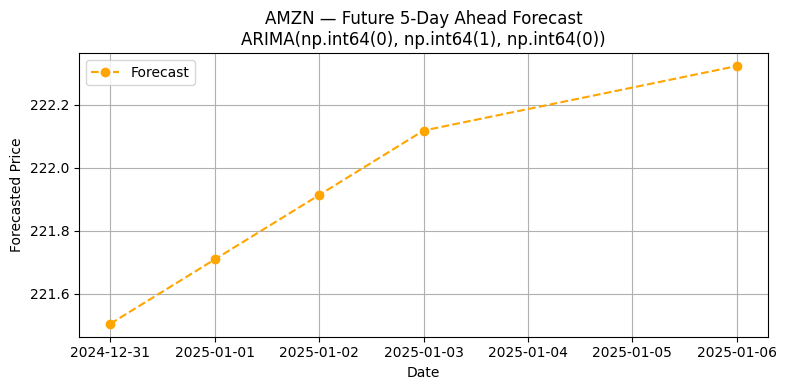

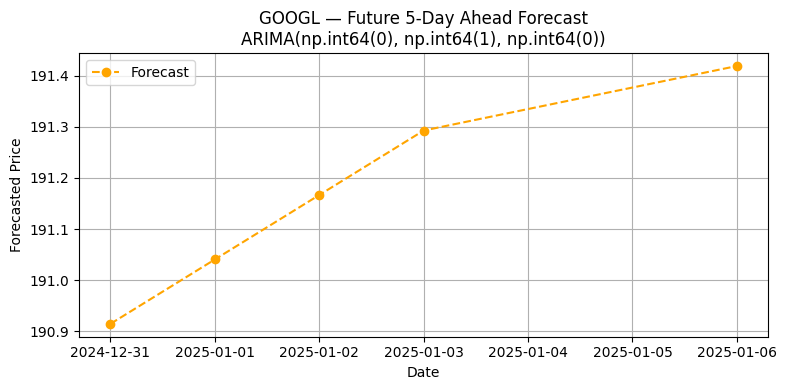

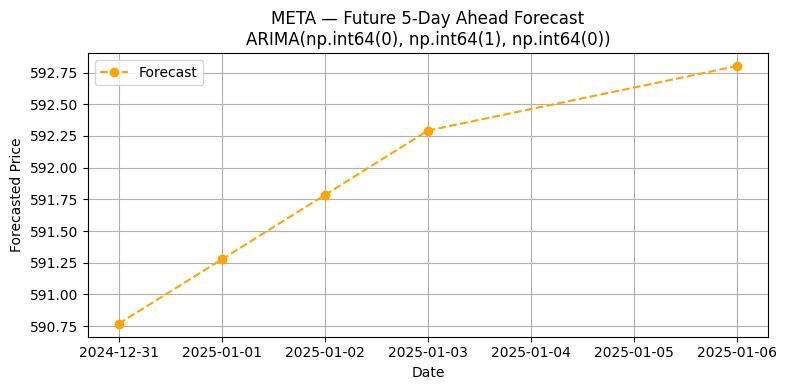

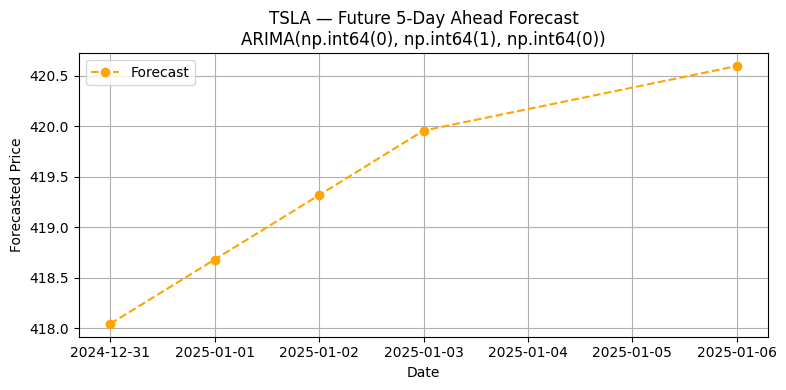

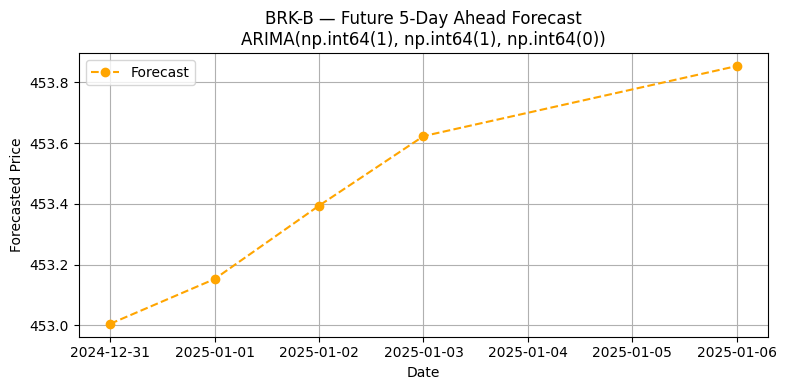

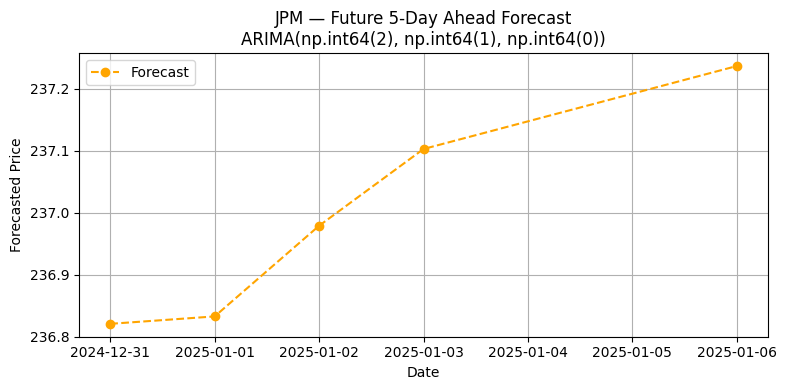

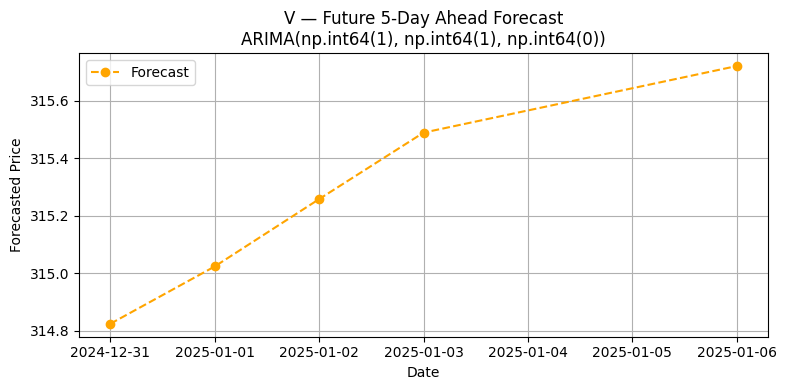

In [20]:
for ticker in forecast_future_df.columns:
    fc = forecast_future_df[ticker]

    plt.figure(figsize=(8, 4))
    plt.plot(fc, marker='o', linestyle='--', color='orange', label='Forecast')
    plt.title(f"{ticker} — Future 5-Day Ahead Forecast\nARIMA{summary_df.loc[summary_df.Ticker == ticker, 'Best_BIC_Order'].values[0]}")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
